# Task 1.1 - Modal → Amodal Mask Prediction Baseline

In [1]:
# !tar -xvzf ff5da6d6ecae486bb294aeaf5ee8f8a1.tar.gz

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pprint import pprint

# Dataset class with safe pair matching
class RGBAtoSegmentationDataset(Dataset):
    def __init__(self, root_path):
        self.obj_paths = [f for f in root_path.rglob("obj_*")]
        self.frames = 24

        assert len(self.obj_paths) > 0, "No matched obj paths found."

        self.transform_img = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.obj_paths)*self.frames

    def __getitem__(self, idx):
        obj = self.obj_paths[idx//self.frames]
        frame = idx % self.frames

        rgb_path = obj.parent / f"rgba_{frame:05d}.png"            #rgb image, full scene
        obj_amod_seg_path = obj / f"segmentation_{frame:05d}.png"  #ground truth
        seg_path = obj.parent / f"segmentation_{frame:05d}.png"    #panoptic segmentation (all objects)

        rgba = Image.open(rgb_path).convert("RGB")
        amod = Image.open(obj_amod_seg_path).convert("L")

        seg_np = np.array(Image.open(seg_path))
        seg_mask = (seg_np == int(obj.name.split("_")[1])).astype(np.uint8)  # binary mask with 0 and 1
        seg_img = Image.fromarray(seg_mask * 255)  # for compatibility with resizing

        rgba = self.transform_img(rgba)
        seg = self.transform_img(seg_img)

        input = torch.cat([rgba, seg], dim=0)
        output = torch.from_numpy(np.array(self.transform_mask(amod)))
        output = (output > 0).long()

        #print(output.max())
        # print("Input shape:", input.shape)
        # print("Output shape:", output.shape)

        return input, output


13248


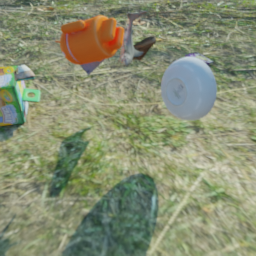

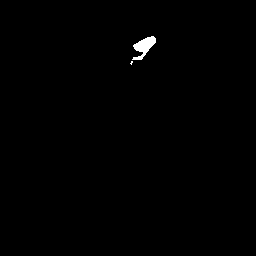

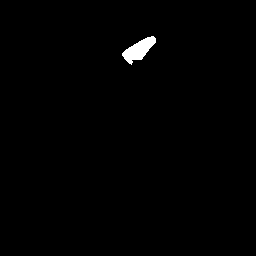

torch.Size([256, 256])

In [2]:
root_path = Path(fr"content")
dataset = RGBAtoSegmentationDataset(root_path)
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
print(len(dataset))
n=722
display(to_pil(dataset[n][0][:3]))  # RGB image
display(to_pil(dataset[n][0][3]))   # Single channel image
display(to_pil(dataset[n][1].float()))      # Label or mask
dataset[n][1].shape

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.insert(3, nn.Dropout2d(0.3))  # Drop between convs
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2, base_channels=64, use_transpose=True):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, base_channels)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4, dropout=True)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(base_channels * 4, base_channels * 8, dropout=True)

        # Decoder
        self.up1 = self._upsample(base_channels * 8, base_channels * 4, use_transpose)
        self.dec1 = ConvBlock(base_channels * 8, base_channels * 4)

        self.up2 = self._upsample(base_channels * 4, base_channels * 2, use_transpose)
        self.dec2 = ConvBlock(base_channels * 4, base_channels * 2)

        self.up3 = self._upsample(base_channels * 2, base_channels, use_transpose)
        self.dec3 = ConvBlock(base_channels * 2, base_channels)

        self.final = nn.Conv2d(base_channels, out_channels, kernel_size=1)

        self._init_weights()

    def _upsample(self, in_ch, out_ch, use_transpose):
        if use_transpose:
            return nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        else:
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_ch, out_ch, kernel_size=1)
            )

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d1 = self.up1(b)
        d1 = torch.cat([d1, e3], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec3(d3)

        return self.final(d3)


In [4]:
# IoU
def compute_iou(pred_mask: torch.Tensor, true_mask: torch.Tensor) -> torch.Tensor:
    # print(pred_mask.shape)
    pred_mask = pred_mask.bool()
    true_mask = true_mask.bool()
    intersection = ((pred_mask & true_mask).sum()).float()
    union = ((pred_mask | true_mask).sum()).float()

    return (intersection + 1e-6) / (union + 1e-6)
# Training
def train_model(model, dataloader, device, epochs=5):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        total_iou = 0.0
        for img, mask in tqdm(dataloader):
            # print(img.shape)  # expect [batch_size, 4, 256, 256]
            # print(mask.shape) # expect [batch_size, 256, 256]
            # print(mask.min(), mask.max())  # should be 0 and 1
            img, mask = img.to(device), mask.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = criterion(out, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            out = (torch.softmax(out, dim=1)[:, 1, :, :] > 0.5)

            total_iou += compute_iou(out, mask).item()
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}, IoU = {total_iou/len(dataloader):.4f}")

# Evaluation
def evaluate_model(model, dataloader, device):
    model.eval()
    total_iou = 0.0
    with torch.no_grad():
        for img, mask in tqdm(dataloader):
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            out = (torch.softmax(out, dim=1)[:, 1, :, :] > 0.5)


            total_iou += compute_iou(out, mask).item()
    print(f"Test IoU = {total_iou / len(dataloader):.4f}")



In [6]:
#Main script
root_path = Path(fr"content")
dataset = RGBAtoSegmentationDataset(root_path)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=4, out_channels=2).to(device)

# Train and evaluate
train_model(model, train_loader, device, epochs=5)
evaluate_model(model, test_loader, device)

Train size: 10598, Test size: 2650


100%|██████████| 1325/1325 [05:14<00:00,  4.21it/s]


Epoch 1: Loss = 0.0167, IoU = 0.7985


100%|██████████| 1325/1325 [05:47<00:00,  3.82it/s]


Epoch 2: Loss = 0.0132, IoU = 0.8043


100%|██████████| 1325/1325 [05:55<00:00,  3.73it/s]


Epoch 3: Loss = 0.0122, IoU = 0.8156


100%|██████████| 1325/1325 [05:44<00:00,  3.84it/s]


Epoch 4: Loss = 0.0116, IoU = 0.8220


100%|██████████| 1325/1325 [05:08<00:00,  4.29it/s]


Epoch 5: Loss = 0.0110, IoU = 0.8259


100%|██████████| 332/332 [00:36<00:00,  9.05it/s]

Test IoU = 0.8149


0.1398601531982422 0.7200000286102295


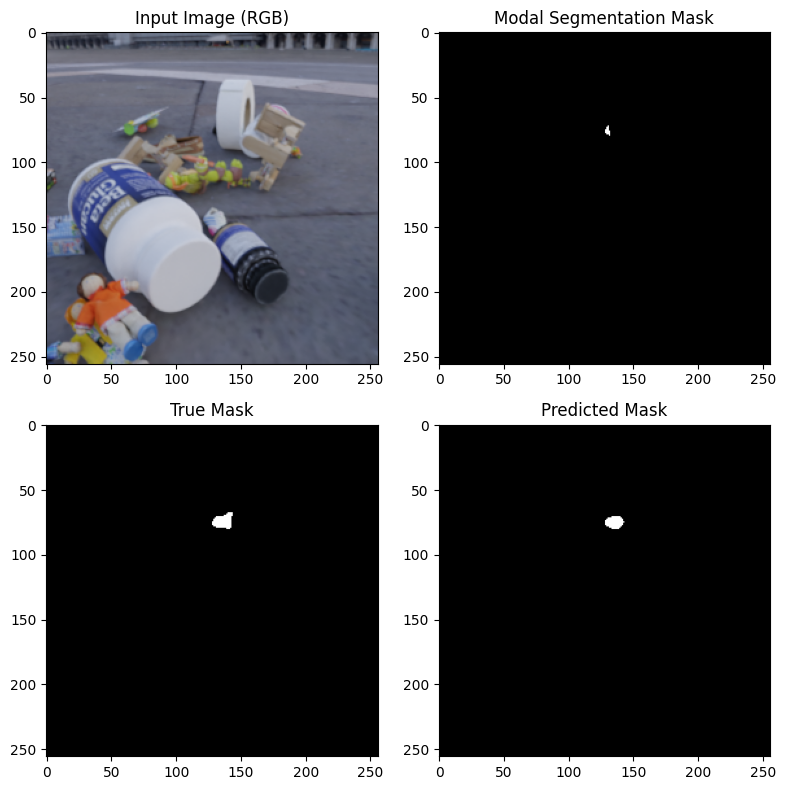

0.19750000536441803 0.5788177251815796


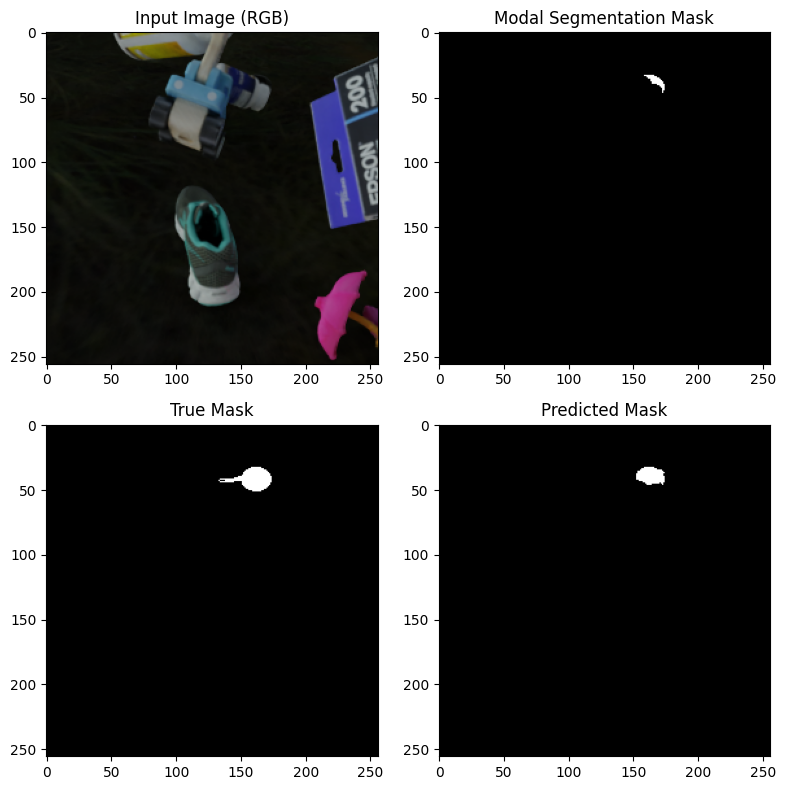

0.2132132202386856 0.5434173941612244


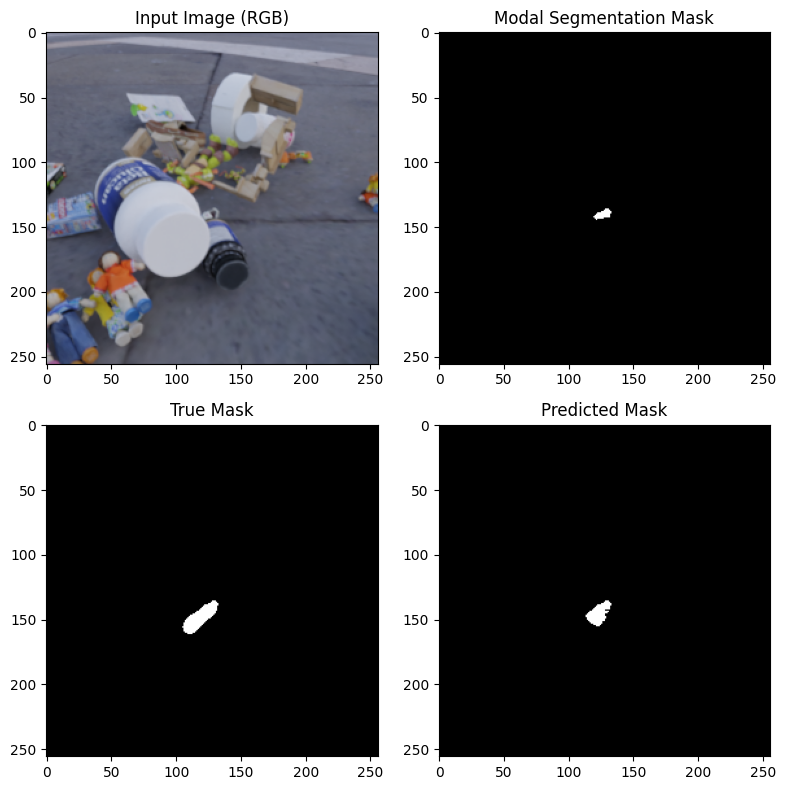

0.27142858505249023 0.9214046597480774


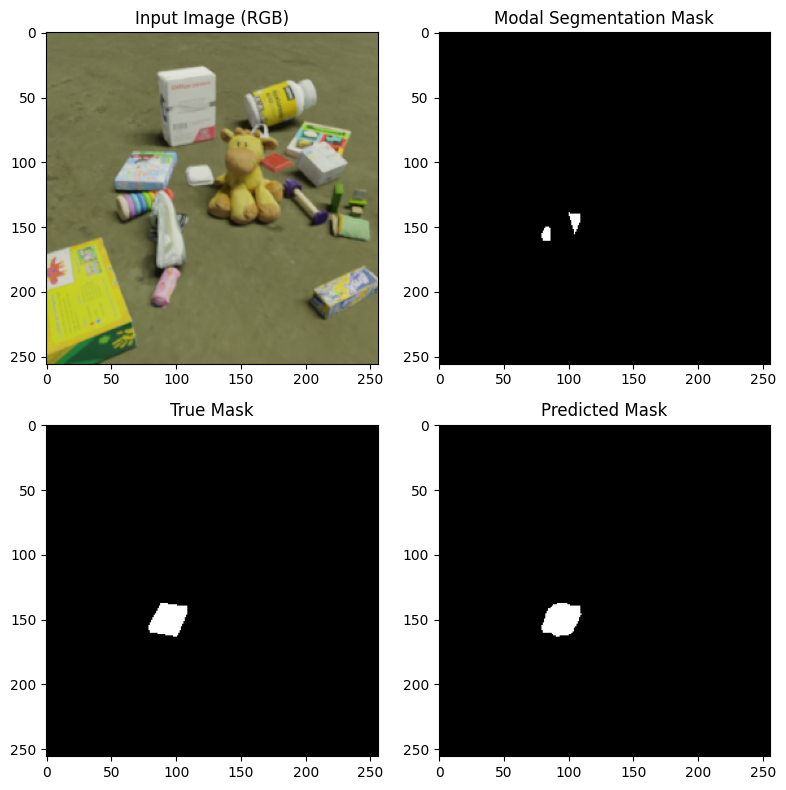

In [12]:
# Optional: Visualize sample prediction
def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    img, true_mask = dataset[idx]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).squeeze()
        pred = (torch.softmax(pred, dim=0)[1] > 0.5)
        # Assume binary segmentation; threshold sigmoid output
        pred_mask = pred.cpu().numpy().astype(np.uint8)

    # Split input: RGB only for display
    rgb_img = img[:3, :, :].permute(1, 2, 0).cpu().numpy()
    seg_img = img[3, :, :].cpu().numpy()

    original_iou = compute_iou(torch.from_numpy(seg_img).to(device),true_mask.to(device)).item()
    new_iou = compute_iou(pred.unsqueeze(0),true_mask.to(device)).item()

    improvement_threshold = 0.3
    if new_iou-original_iou>improvement_threshold:
      print(original_iou,new_iou)

      fig, axs = plt.subplots(2, 2, figsize=(8, 8))
      axs[0][0].imshow(rgb_img)
      axs[0][0].set_title("Input Image (RGB)")

      axs[0][1].imshow(seg_img, cmap="gray")
      axs[0][1].set_title("Modal Segmentation Mask")

      axs[1][0].imshow(true_mask, cmap="gray")
      axs[1][0].set_title("True Mask")

      axs[1][1].imshow(pred_mask, cmap="gray")
      axs[1][1].set_title("Predicted Mask")

      plt.tight_layout()
      plt.show()

# Visualize prediction from test set
for i in range(100):
  visualize_prediction(model, test_set, device, idx=i)

In [9]:
torch.save(model.state_dict(), "model_weights.pth")


In [ ]:
model = UNet(in_channels=4, out_channels=2).to(device)
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()  # Important for evaluation


0.3289855122566223 0.7616822719573975


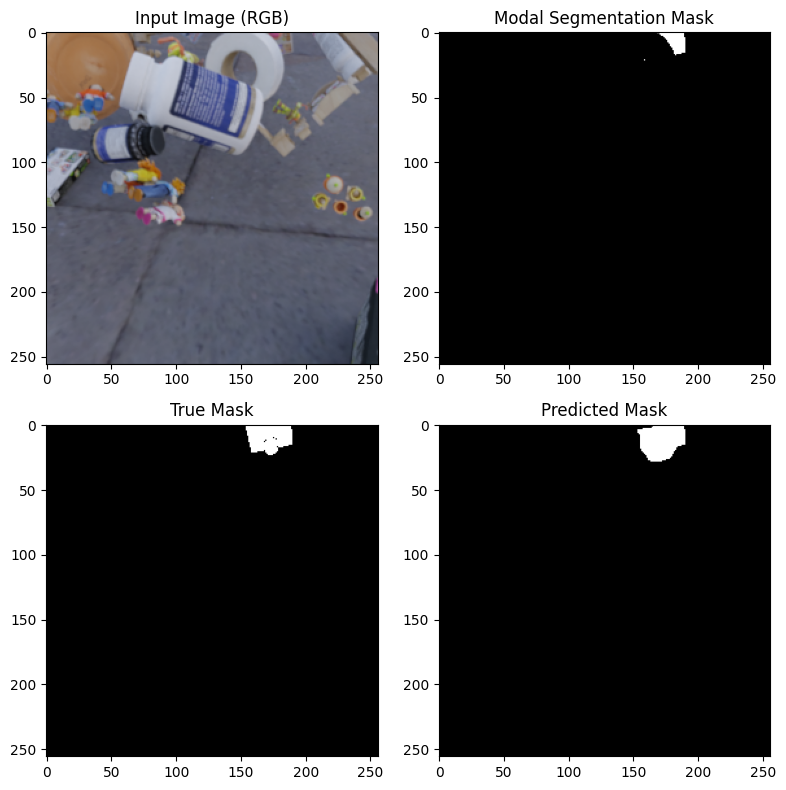

0.17873303592205048 0.4974515736103058


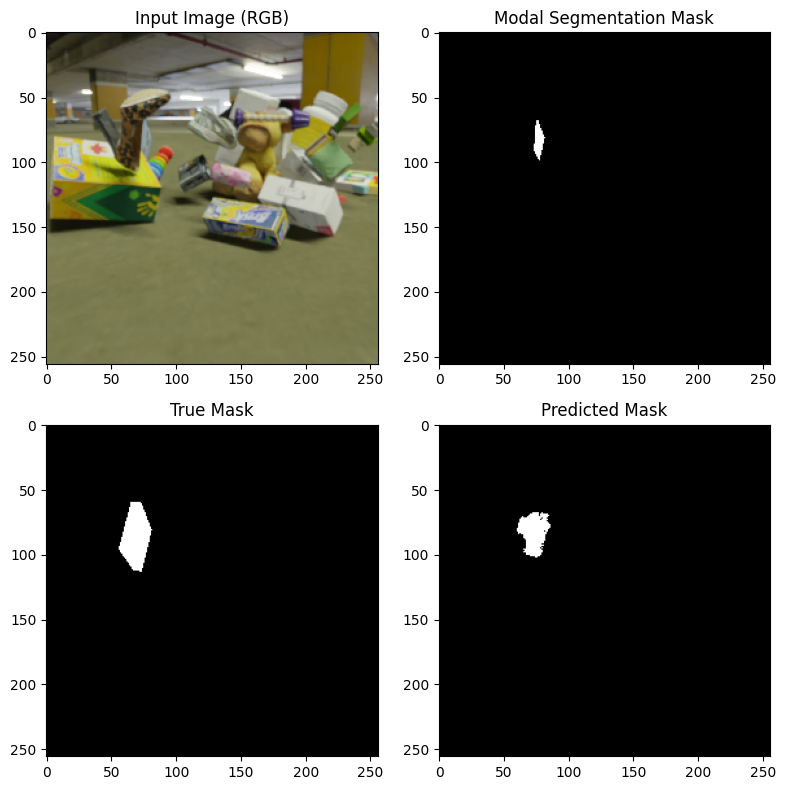

0.3707296550273895 0.7899505496025085


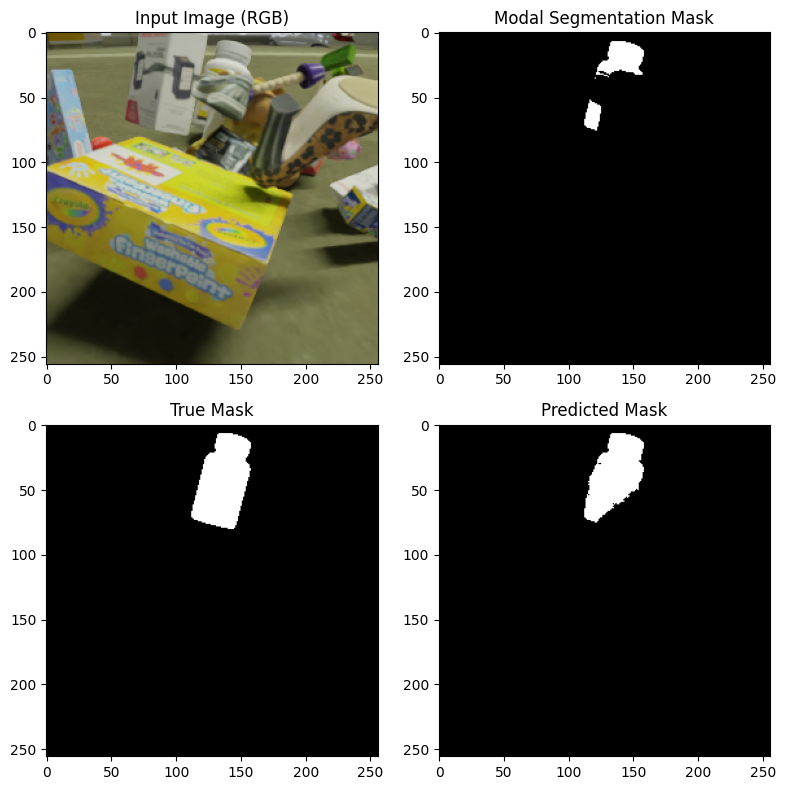

0.4687890112400055 0.8326100707054138


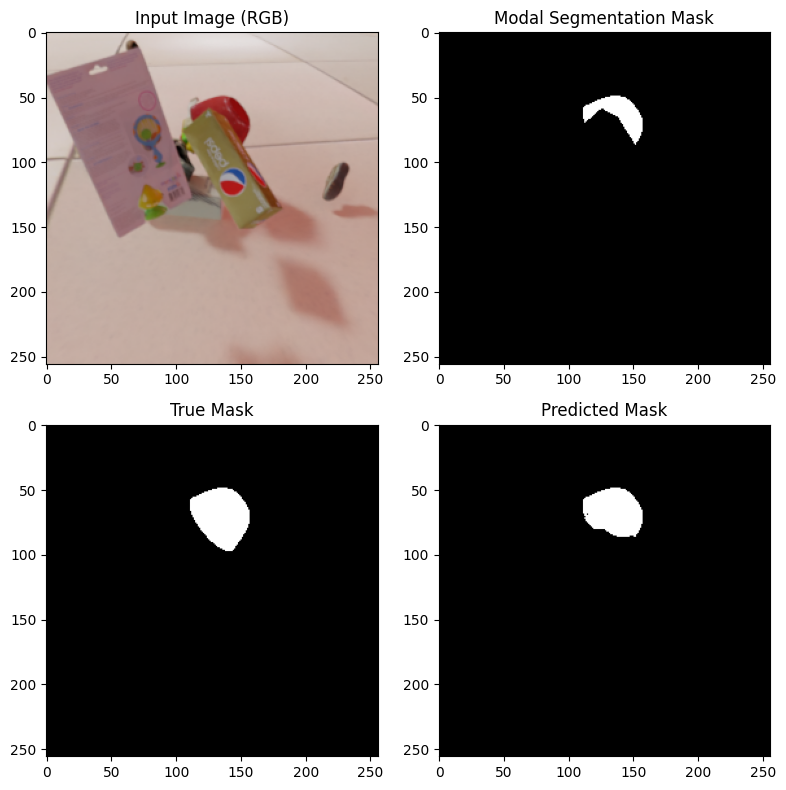

0.15920716524124146 0.565937340259552


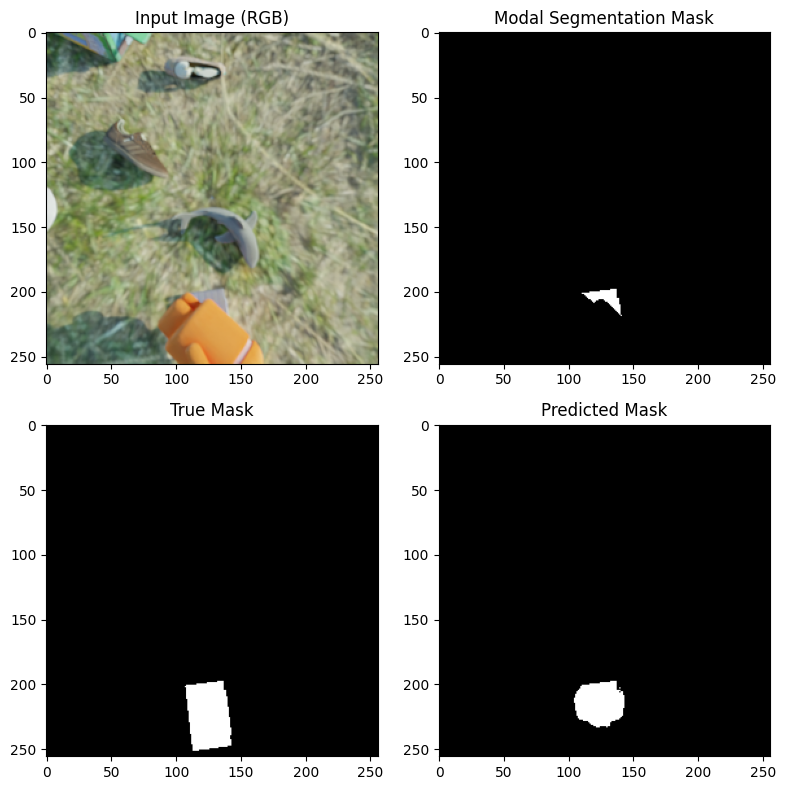

0.2981458604335785 0.6332384943962097


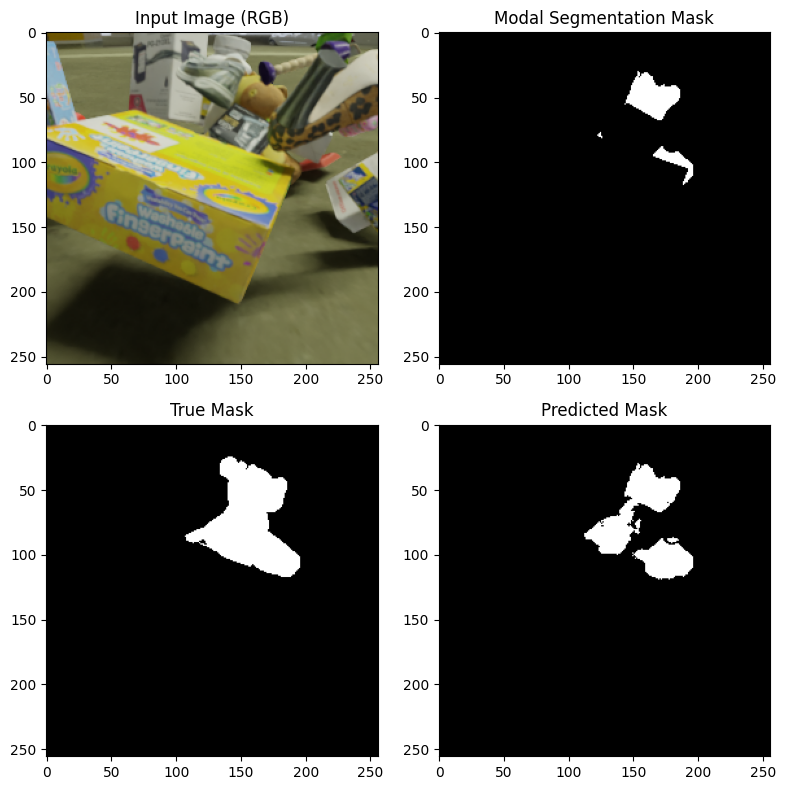

0.0765027329325676 0.42278480529785156


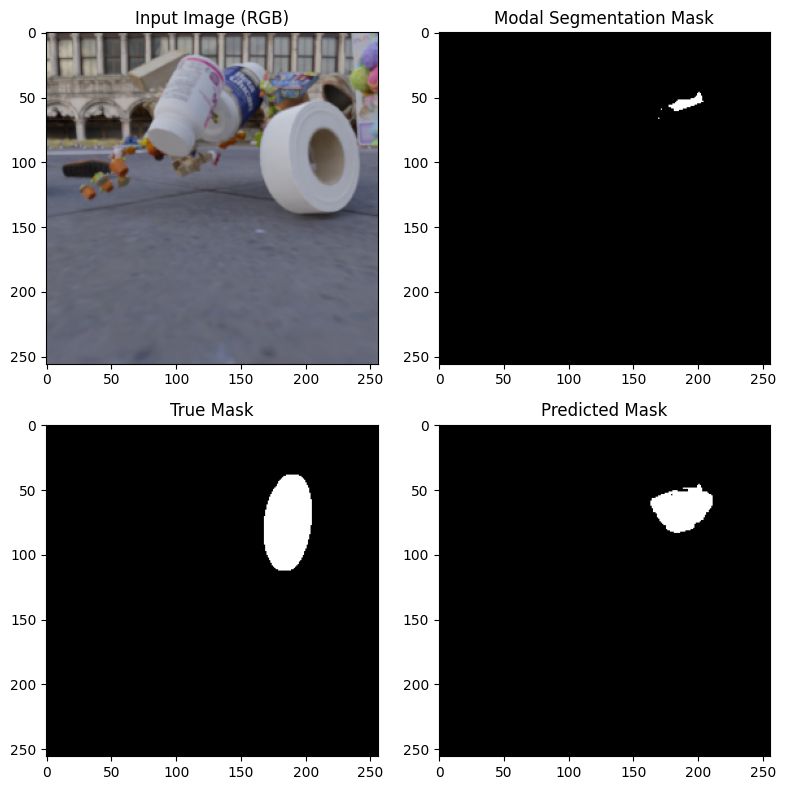

0.24941176176071167 0.8932306170463562


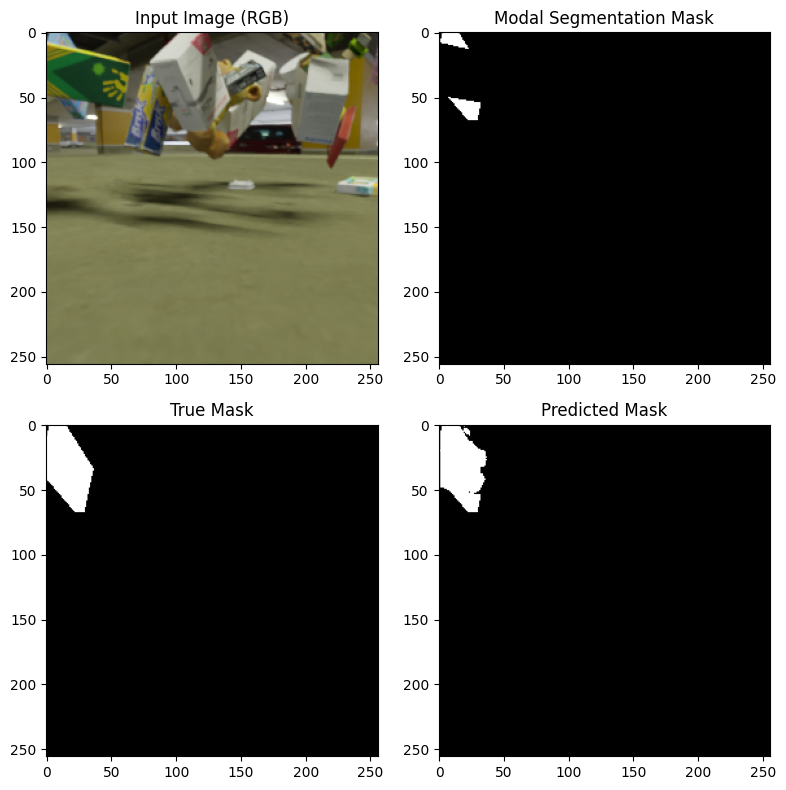

0.04054054245352745 0.5066921710968018


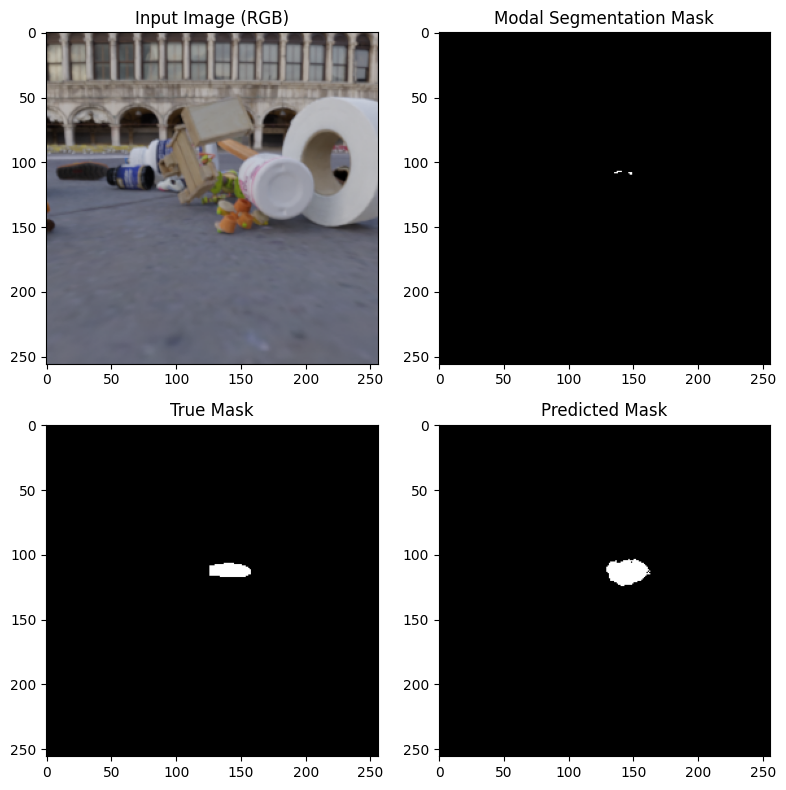

In [15]:
for i in range(100, 200):
    visualize_prediction(model, test_set, device, idx=i)